In [ ]:
#此代码为基于随机森林模型，计算各变量趋势VI

In [15]:
# 多元回归_yearly_VI
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn import metrics
from scipy.io import loadmat
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib
import os
import xlsxwriter
from scipy import stats
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.ticker as ticker
from scipy.stats import norm
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.size'] = 15
plt.rcParams['axes.unicode_minus'] = False
plt.subplots_adjust(wspace=0, hspace=150)
plt.tight_layout()

running_num = 1000
fig_rows = 1
fig_cols = 1
best_nse = -100
best_model = None
training_proportion_range = [0.7]
year_range = [2004, 2016, 2017]          # 需要移除的潜在异常年份
removed_years = '2004, 2016, 2017'       # year_range的字符串表示
VI_total = [[] for i in range(12)]
VI_nse_array = [[] for i in range(12)]
VI_rmse_array = [[] for i in range(12)]
VI_nse_array_threshold = [[] for i in range(12)]
VI_rmse_array_threshold = [[] for i in range(12)]
nse_threshold = 0.4                      # NSE > nse_threshold的例子才加入VI中

shuffle_factor = ['no', 'chla', 'DIN', 'WS', 'Current', 'temp']
#factors = ('chla', 'temp', 'DIN', 'density', 'WS', 'Current')
factors1 = ('chla','DIN','WS')
factors2 = ('chla','DIN','WS','Current','temp')
factors3 = ('chla','DIN','WS','DIN_SD','chla_SD')
factors_all = ('chla', 'temp', 'DIN', 'density', 'chla_SD', 'std_temp_SD', 'DIN_SD', 'density_SD', 'WS', 'Current')
factors_best = ('chla_SD', 'std_temp_SD', 'DIN_SD', 'density_SD', 'WS')

<Figure size 432x288 with 0 Axes>

In [2]:
#这里的real和pred都是np.array格式，默认传入的real和pred的size一样
#算NSE
def cal_NSE(real, pred, mean):
    numerator=0
    denominator=0
    for it in range(len(real)):
        numerator += (pred[it]-real[it]) ** 2
        denominator += (real[it]-mean) ** 2
    nse = 1 - numerator/denominator
    return nse

#算RMSE
def cal_RMSE(real, pred):
    n = len(pred)
    numerator = 0
    for it in range(len(pred)):
        numerator += (pred[it] - real[it]) * (pred[it] - real[it])
    RMSE = (numerator/n) ** 0.5
    return RMSE

#算Pcorr,mean是所有数据的mean还是test的mean
def cal_Pcorr(real, pred, mean):
    pred_mean = pred.mean(axis=0)
    numerator=0
    denominator=0
    a = 0
    b = 0
    for it in range(len(pred)):
        numerator += (pred[it]-pred_mean)*(real[it]-mean)
        a += (pred[it]-pred_mean) ** 2
        b += (real[it]-mean) ** 2
    denominator = (a*b) ** 0.5
    Pcorr = numerator / denominator
    return Pcorr

#计算Theil-Sen Slope(type(data) == np.darray)
def sen_slope(data):
    slopes = []
    for i in range(data.shape[0] - 1):
        for j in range(i + 1, data.shape[0]):
            slopes.append((data[i] - data[j]) / (i - j))
            
    slopes = np.sort(slopes)
    n = len(slopes)
    return (slopes[int(n / 2)] + slopes[int((n + 1) / 2)]) / 2

#计算Kenn-Mandall系数
# |z| >= 1.28, a > 90%; |z| >= 1.64, a > 95%; |z| >= 2.32, a > 99%
def KM(data):
    n = data.shape[0]
    s = 0
    for i in np.arange(n - 1):
        for j in np.arange(i + 1, n):
            if data[j] > data[i]:
                s = s + 1
            elif data[j] < data[i]:
                s = s - 1
    
    std = np.sqrt(n * (n - 1) * (2 * n + 5) / 18)
    if s > 0:
        z = (s - 1) / std
    elif s < 0:
        z = (s + 1) / std
    else:
        z = 0
    return z

In [3]:
#DataSet is the name of the DataSet
#Data contains P_val, NSE and RMSE
#workbook has been created in main function
def write_excel(workbook,sheet_name,total,nse_test_array, nse_train_array):    
    worksheet = workbook.add_worksheet(sheet_name) #create a sheet for DataSet
    worksheet.write(1,0,'test_data')
    worksheet.write(2,0,'train_data')
    worksheet.write(0,1,'nse_mean')
    worksheet.write(0,2,'nse_std')
    worksheet.write(0,3,'nse_min')
    worksheet.write(0,4,'nse_max')
    worksheet.write(1,1,nse_test_array[0])
    worksheet.write(1,2,nse_test_array[1])
    worksheet.write(1,3,nse_test_array[2])
    worksheet.write(1,4,nse_test_array[3])
    worksheet.write(2,1,nse_train_array[0])
    worksheet.write(2,2,nse_train_array[1])
    worksheet.write(2,3,nse_train_array[2])
    worksheet.write(2,4,nse_train_array[3])
    
    worksheet.write(4,0,'序号')
    worksheet.set_column('A:A',10)#设置第2列宽度为20像素
    #worksheet.write(3,1,'模型')
    worksheet.write(4,1,'Pcorr')
    worksheet.write(4,2,'NSE')
    worksheet.write(4,3,'RMSE')
    worksheet.write(4,4,'pvalue')
    for r in range(int(len(total))):
        worksheet.write(r+5,0,r)
        #worksheet.write(r+1,1,total[r]['factors_str'])
        worksheet.write(r+5,1,total[r]['pcorr'])
        worksheet.write(r+5,2,total[r]['nse'])
        worksheet.write(r+5,3,total[r]['rmse'])
        worksheet.write(r+5,4,total[r]['pvalue'])

In [4]:
# listing all file names: all .mat file in my computer are stored in ./data/ directory 
file_names = ['HI_yearly']
file_dir = 'C:/Users/admin/data1/'
dt = np.dtype([('factors_str',str,80), ('r_2_0', float), ('nse', float), ('rmse', float), \
    ('pcorr', float), ('test_y', np.ndarray), ('test_pred', np.ndarray),('train_pred', np.ndarray), ('pvalue', float), \
    ('window_size', int), ('training_proportion', float), ('test_year', np.ndarray), \
    ('train_year', np.ndarray)])

selected_kinds:  ['chla', 'DIN', 'WS', 'Current', 'temp']
1000


<ipython-input-16-78a6fb6e7036>:236: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  subfigures[kk].scatter(x, data['HI'], marker='o', edgecolor='r', s=70, linewidths=3, color='', label='HI实际数据点')


selected_kinds:  ['chla', 'DIN', 'WS', 'Current', 'temp']
1000
selected_kinds:  ['chla', 'DIN', 'WS', 'Current', 'temp']


<ipython-input-16-78a6fb6e7036>:236: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  subfigures[kk].scatter(x, data['HI'], marker='o', edgecolor='r', s=70, linewidths=3, color='', label='HI实际数据点')


1000
selected_kinds:  ['chla', 'DIN', 'WS', 'Current', 'temp']


<ipython-input-16-78a6fb6e7036>:236: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  subfigures[kk].scatter(x, data['HI'], marker='o', edgecolor='r', s=70, linewidths=3, color='', label='HI实际数据点')


1000
selected_kinds:  ['chla', 'DIN', 'WS', 'Current', 'temp']


<ipython-input-16-78a6fb6e7036>:236: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  subfigures[kk].scatter(x, data['HI'], marker='o', edgecolor='r', s=70, linewidths=3, color='', label='HI实际数据点')


1000
selected_kinds:  ['chla', 'DIN', 'WS', 'Current', 'temp']


<ipython-input-16-78a6fb6e7036>:236: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  subfigures[kk].scatter(x, data['HI'], marker='o', edgecolor='r', s=70, linewidths=3, color='', label='HI实际数据点')


1000


<ipython-input-16-78a6fb6e7036>:236: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  subfigures[kk].scatter(x, data['HI'], marker='o', edgecolor='r', s=70, linewidths=3, color='', label='HI实际数据点')


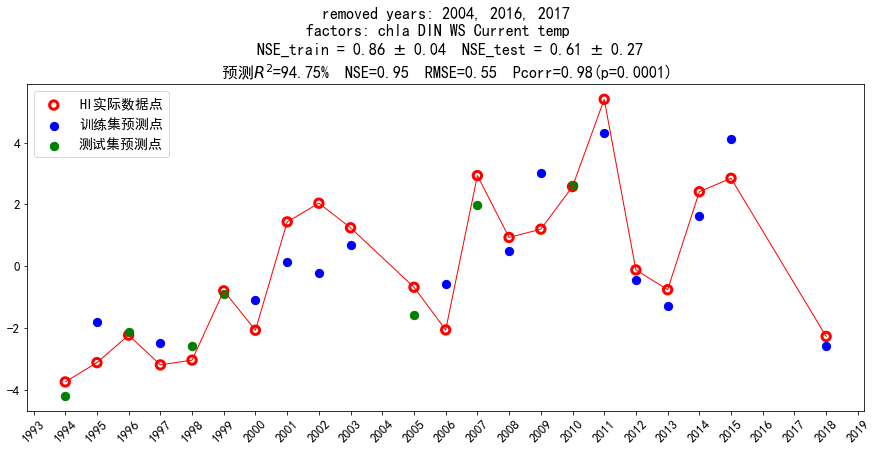

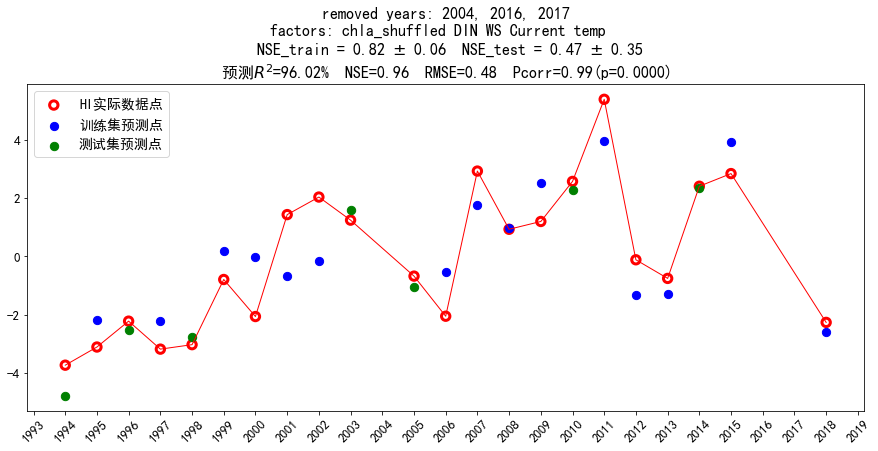

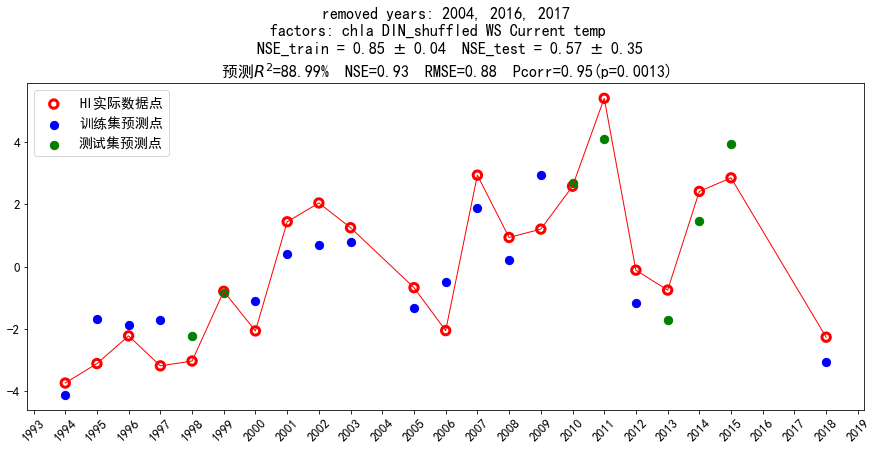

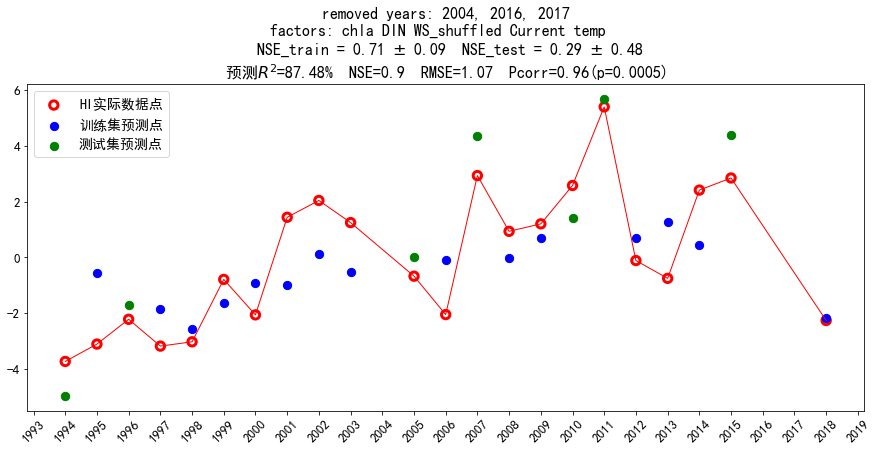

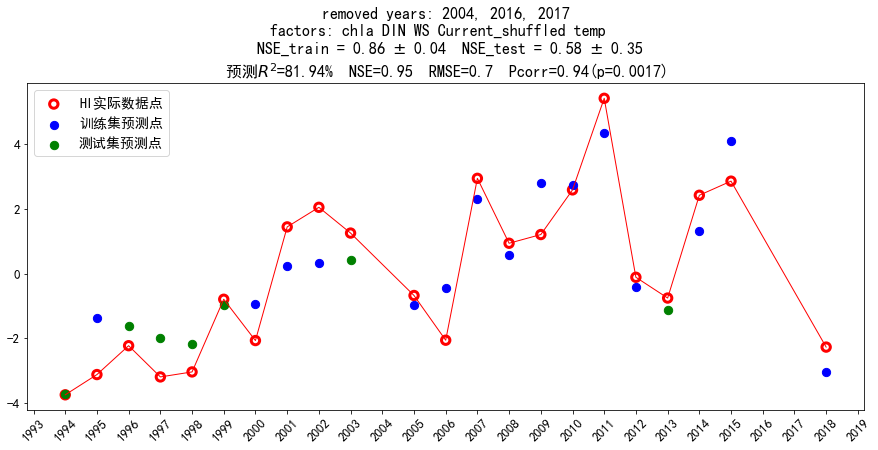

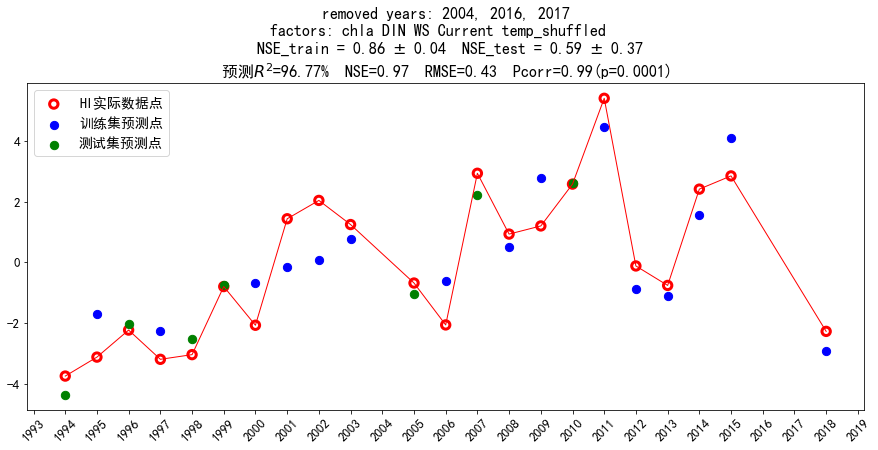

In [16]:
workbook = xlsxwriter.Workbook('HI_多元回归_' + str(int(training_proportion_range[0] * 10)) + '_yearly.xlsx') #create a excel table named result.xlsx
# reading data from .mat
for name in file_names:
    for training_proportion in training_proportion_range:
        if training_proportion == 1:
            running_num = 10
        for shuffle in range(6):
            file_path = file_dir + name + '.mat'
            data = loadmat(file_path)['X']
            data = pd.DataFrame(data, columns=('chla', 'temp', 'DIN', 'density', 'chla_SD', 'std_temp_SD', \
                                               'DIN_SD', 'density_SD', 'WS', 'Current', 'HI', 'year'))
            window_size = 1
            
            if shuffle > 0:
                data[shuffle_factor[shuffle]] = data[shuffle_factor[shuffle]].sample(frac=1).reset_index(drop=True)
            
            # converting data type
            data['year'] = data['year'].astype('i4')
            data = data[[x not in year_range for x in data['year']]]
            all_kinds = []
    
            #all_kinds.append(list(factors1))
            all_kinds.append(list(factors2))
            Data = []
            total_display = []
            fig = subfigure = []
            fig, subfigure = plt.subplots(fig_rows, fig_cols, figsize=(15 * fig_cols, 6 * fig_rows))
            subfigures = []
            for i in range(fig_cols):
                if fig_rows == 1:
                    subfigures.append(subfigure)
                    break
                for subfigs in subfigure:
                    if fig_cols == 1:
                        subfigures.append(subfigs)
                    else:
                        subfigures.append(subfigs[i])
            
            nse_train_array = []
            nse_test_array = []
            rmse_train_array = []
            rmse_test_array = []
            nse_train_array_threshold = []
            nse_test_array_threshold = []
            rmse_test_array_threshold = []
            # for each combination of factors
            for k in range(len(all_kinds)):
                total = np.array([], dtype=dt)
                all_test_nse = []
                all_train_nse = []
                all_test_rmse = []
                all_train_rmse = []
                threshold_test_nse = []
                threshold_train_nse = []
                threshold_test_rmse = []
                selected_kinds = all_kinds[k]
                factors_str = ''
                for i in selected_kinds:
                    factors_str += i
                    factors_str += ' '
                
                Data.append(factors_str)
                print("selected_kinds: ",selected_kinds)
                selected_kinds.append('year')
                
                # constructing datasets
                X = data[selected_kinds]
                Y = data['HI']
                selected_kinds.remove('year')
                
                for i in range(running_num):
                    if training_proportion == 1:
                        all_train = all_test = X
                        Y_train = Y_test = Y
                    else:
                        all_train, all_test, Y_train, Y_test = train_test_split(X, Y, test_size=(1 - training_proportion), random_state=i)
                    X_train = all_train[selected_kinds]
                    X_test = all_test[selected_kinds]
                    
                    #data preprocessing: data standardization
                    X_mean = X_train.mean(axis=0)
                    X_std = X_train.std(axis=0)
                    Y_mean = Y_train.mean(axis=0)
                    Y_std = Y_train.std(axis=0)
                    X_train_norm = (X_train - X_mean) / X_std
                    Y_train_norm = (Y_train - Y_mean) / Y_std
                    X_test_norm = (X_test - X_mean) / X_std
                    Y_test_norm = (Y_test - Y_mean) / Y_std

                    #多元回归模型
                    # clf = RandomForestRegressor(n_estimators=10, random_state=45, bootstrap=True)
                    clf = LinearRegression()
                    clf.fit(X_train_norm, Y_train_norm)
                    test_pred = clf.predict(X_test_norm)
                    train_pred = clf.predict(X_train_norm)
                    clf_test_pred = test_pred * Y_std + Y_mean
                    clf_train_pred = train_pred * Y_std + Y_mean
                    
                    #计算R2
                    R_2_0 = metrics.r2_score(Y_test.values, clf_test_pred) 
                    
                    #计算NSE, RMSE, Pcorr
                    NSE_test = cal_NSE(Y_test.values, clf_test_pred, Y_mean)
                    NSE_train = cal_NSE(Y_train.values, clf_train_pred, Y_mean)
                    RMSE = cal_RMSE(Y_test.values, clf_test_pred)
                    RMSE_train = cal_RMSE(Y_train.values, clf_train_pred)

                    pearson = stats.pearsonr(np.array(Y_test, dtype='float'), np.array(clf_test_pred, dtype='float'))
                    Pcorr = pearson[0]
                    pvalue = pearson[1]
                
                    Data.append(Pcorr)
                    Data.append(NSE_test)
                    Data.append(RMSE)
                    all_test_nse.append(NSE_test)
                    all_train_nse.append(NSE_train)
                    all_test_rmse.append(RMSE)
                    all_train_rmse.append(RMSE_train)
                    
                    if shuffle == 0 and NSE_test > best_nse:
                        best_nse = NSE_test
                        best_model = clf

                    # threshold_test_nse contents only nse that nse > nse_threshold
                    if NSE_test > nse_threshold:
                        threshold_test_nse.append(NSE_test)
                        threshold_train_nse.append(NSE_train)
                        threshold_test_rmse.append(RMSE)
                    test_year = all_test['year'][:]
                    train_year = all_train['year'][:]
                    item = (factors_str, R_2_0, NSE_test, RMSE, Pcorr, Y, clf_test_pred, clf_train_pred, pvalue, \
                            window_size, training_proportion, test_year, train_year)
                    total = np.append(total, np.array(item, dtype=dt))

                print(len(total))
                nse_test_mean = np.mean(all_test_nse)
                nse_test_std = np.std(all_test_nse, ddof=1)
                nse_test_sorted = sorted(all_test_nse)
                nse_test_max = nse_test_sorted[len(nse_test_sorted) - 1]
                nse_test_min = nse_test_sorted[0]
                nse_test_array.append(nse_test_mean)
                nse_test_array.append(nse_test_std)
                nse_test_array.append(nse_test_min)
                nse_test_array.append(nse_test_max)
                
                nse_train_mean = np.mean(all_train_nse)
                nse_train_std = np.std(all_train_nse, ddof=1)
                nse_train_sorted = sorted(all_train_nse)
                nse_train_max = nse_train_sorted[len(nse_train_sorted) - 1]
                nse_train_min = nse_train_sorted[0]
                nse_train_array.append(nse_train_mean)
                nse_train_array.append(nse_train_std)
                nse_train_array.append(nse_train_min)
                nse_train_array.append(nse_train_max)
                
                # append nse where nse > nse_threshold
                nse_test_mean = np.mean(threshold_test_nse)
                nse_test_std = np.std(threshold_test_nse, ddof=1)
                nse_test_sorted = sorted(threshold_test_nse)
                nse_test_max = nse_test_sorted[len(nse_test_sorted) - 1]
                nse_test_min = nse_test_sorted[0]
                nse_test_array_threshold.append(nse_test_mean)
                nse_test_array_threshold.append(nse_test_std)
                nse_test_array_threshold.append(nse_test_min)
                nse_test_array_threshold.append(nse_test_max)
                
                nse_train_mean = np.mean(threshold_train_nse)
                nse_train_std = np.std(threshold_train_nse, ddof=1)
                nse_train_sorted = sorted(threshold_train_nse)
                nse_train_max = nse_train_sorted[len(nse_train_sorted) - 1]
                nse_train_min = nse_train_sorted[0]
                nse_train_array_threshold.append(nse_train_mean)
                nse_train_array_threshold.append(nse_train_std)
                nse_train_array_threshold.append(nse_train_min)
                nse_train_array_threshold.append(nse_train_max)
                
                # append rmse
                rmse_test_mean = np.mean(all_test_rmse)
                rmse_test_std = np.std(all_test_rmse, ddof=1)
                rmse_test_array.append(rmse_test_mean)
                rmse_test_array.append(rmse_test_std)
                
                rmse_train_mean = np.mean(all_train_rmse)
                rmse_train_std = np.std(all_train_rmse, ddof=1)
                rmse_train_array.append(rmse_train_mean)
                rmse_train_array.append(rmse_train_std)
                
                rmse_test_mean = np.mean(threshold_test_rmse)
                rmse_test_std = np.std(threshold_test_rmse, ddof=1)
                rmse_test_array_threshold.append(rmse_test_mean)
                rmse_test_array_threshold.append(rmse_test_std)
                
                # sort the predicted results by NSE
                total = sorted(total, key=lambda x: x['nse'])
                total = np.flipud(total)
                total_display.append(total[0])
                if shuffle == 0:
                    write_excel(workbook, factors_str, total, nse_test_array[4 * k: ], nse_train_array[4 * k: ])#write result into excel file

            for kk in range(1):
                # 建立时间戳，作为图表下标
                total = total_display[kk]
                window_size = total['window_size']
                training_proportion = total['training_proportion']
                years = list(data['year'])

                # add the best model to VI_total: (originral: 0, chla: 1, DIN: 2, WS: 3, Current: 4, temp: 5)
                if shuffle > 0:
                    total['factors_str'] = total['factors_str'].replace(shuffle_factor[shuffle], shuffle_factor[shuffle] + '_shuffled')

                # VI_nse_array contents only nse where test_nse > nse_threshold
                VI_total[2 * shuffle + kk] = total
                VI_nse_array[2 * shuffle + kk] = (nse_train_array[4 * kk], nse_train_array[4 * kk + 1], \
                                                  nse_test_array[4 * kk], nse_test_array[4 * kk + 1])
                VI_nse_array_threshold[2 * shuffle + kk] = (nse_train_array_threshold[4 * kk], nse_train_array_threshold[4 * kk + 1], \
                                                  nse_test_array_threshold[4 * kk], nse_test_array_threshold[4 * kk + 1])
                VI_rmse_array[2 * shuffle + kk] = (rmse_train_array[2 * kk], rmse_train_array[2 * kk + 1], \
                                                  rmse_test_array[2 * kk], rmse_test_array[2 * kk + 1])
                VI_rmse_array_threshold[2 * shuffle + kk] = (rmse_test_array_threshold[2 * kk], rmse_test_array_threshold[2 * kk + 1])

                test_years = total['test_year']
                train_years = total['train_year']
                x = [str(year) for year in years]
                x = [datetime.strptime(i, '%Y') for i in x]
                x = matplotlib.dates.date2num(x)
                test_x = [str(year) for year in test_years]
                test_x = [datetime.strptime(i, '%Y') for i in test_x]
                test_x = matplotlib.dates.date2num(test_x)
                train_x = [str(year) for year in train_years]
                train_x = [datetime.strptime(i, '%Y') for i in train_x]
                train_x = matplotlib.dates.date2num(train_x)
                # 实际值与预测值对比图
                plt.subplots_adjust(wspace=0, hspace=0.5)

                subfigures[kk].plot(x, data['HI'], 'r-', linewidth=1, label='')
                subfigures[kk].scatter(x, data['HI'], marker='o', edgecolor='r', s=70, linewidths=3, color='', label='HI实际数据点')
                subfigures[kk].scatter(train_x, total['train_pred'], s=68, label='训练集预测点', color = 'b')
                subfigures[kk].scatter(test_x, total['test_pred'], s=70, label='测试集预测点', color = 'g')
                subfigures[kk].set_xticklabels(labels=x, rotation=45, size = 13)
                subfigures[kk].tick_params(labelsize=13)
                subfigures[kk].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
                subfigures[kk].xaxis.set_major_locator(matplotlib.dates.YearLocator())
                subfigures[kk].legend(loc='upper left', fontsize=14)


                subfigures[kk].set_title('removed years: ' + removed_years + '\nfactors: {4} \n NSE_train = {0:.2f} $\pm$ {1:.2f}  NSE_test = {2:.2f} $\pm$ {3:.2f}\n'\
                     .format(nse_train_array[4 * kk], nse_train_array[4 * kk + 1], nse_test_array[4 * kk], nse_test_array[4 * kk + 1], str(total['factors_str'])) \
                    + '预测$R^2$={5}%  NSE={1}  RMSE={2}  Pcorr={3}(p={4:.4f})'.format(\
                    str(total['factors_str']), round(total['nse'],2), round(total['rmse'],2), round(total['pcorr'],2), round(total['pvalue'],4), \
                    round(total['r_2_0']* 100, 2), total['window_size'], round(total['training_proportion'], 1)), size=16)
            
            if shuffle == 0:
                #plt.savefig('HI_多元回归_'+ str(k) + '_' + str(int(training_proportion * 10)) + 'yearly.pdf')
                plt.savefig('HI_多元回归_去除变量预测' + str(int(training_proportion * 10)) + '_yearly.png')
workbook.close() #close excel file

In [6]:
def num2str(num):
    s = ''
    if num == 0:
        s += '(a)'
    if num == 1:
        s += '(b)'
    if num == 2:
        s += '(c)'
    if num == 3:
        s += '(d)'
    if num == 4:
        s += '(e)'
    if num == 5:
        s += '(f)'
    return s

chla_detrend HI: k = 0.28, KM = 2.93
DIN_detrend HI: k = 0.28, KM = 2.93
WS_detrend HI: k = 0.28, KM = 2.93
Current_detrend HI: k = 0.28, KM = 2.93
temp_detrend HI: k = 0.28, KM = 2.93


<ipython-input-8-b580a0dddf1e>:46: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  subfigures[kk].scatter(x, y, marker='o', edgecolor=colors[kk], s=70, linewidths=3, color='', label=data.columns[kk] + '_detrend ' + 'HI')
<ipython-input-8-b580a0dddf1e>:46: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  subfigures[kk].scatter(x, y, marker='o', edgecolor=colors[kk], s=70, linewidths=3, color='', label=data.columns[kk] + '_detrend ' + 'HI')
<ipython-input-8-b580a0dddf1e>:46: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  subfigures[kk].scatter(x, y, marker='o', edgecolor=colors[kk], s=70, linewidths=3, color='', label=data.columns[kk] + '_detrend ' + 'HI')
<ipython-input-8-b580a0dddf1e>:46: MatplotlibDeprecationWarning:

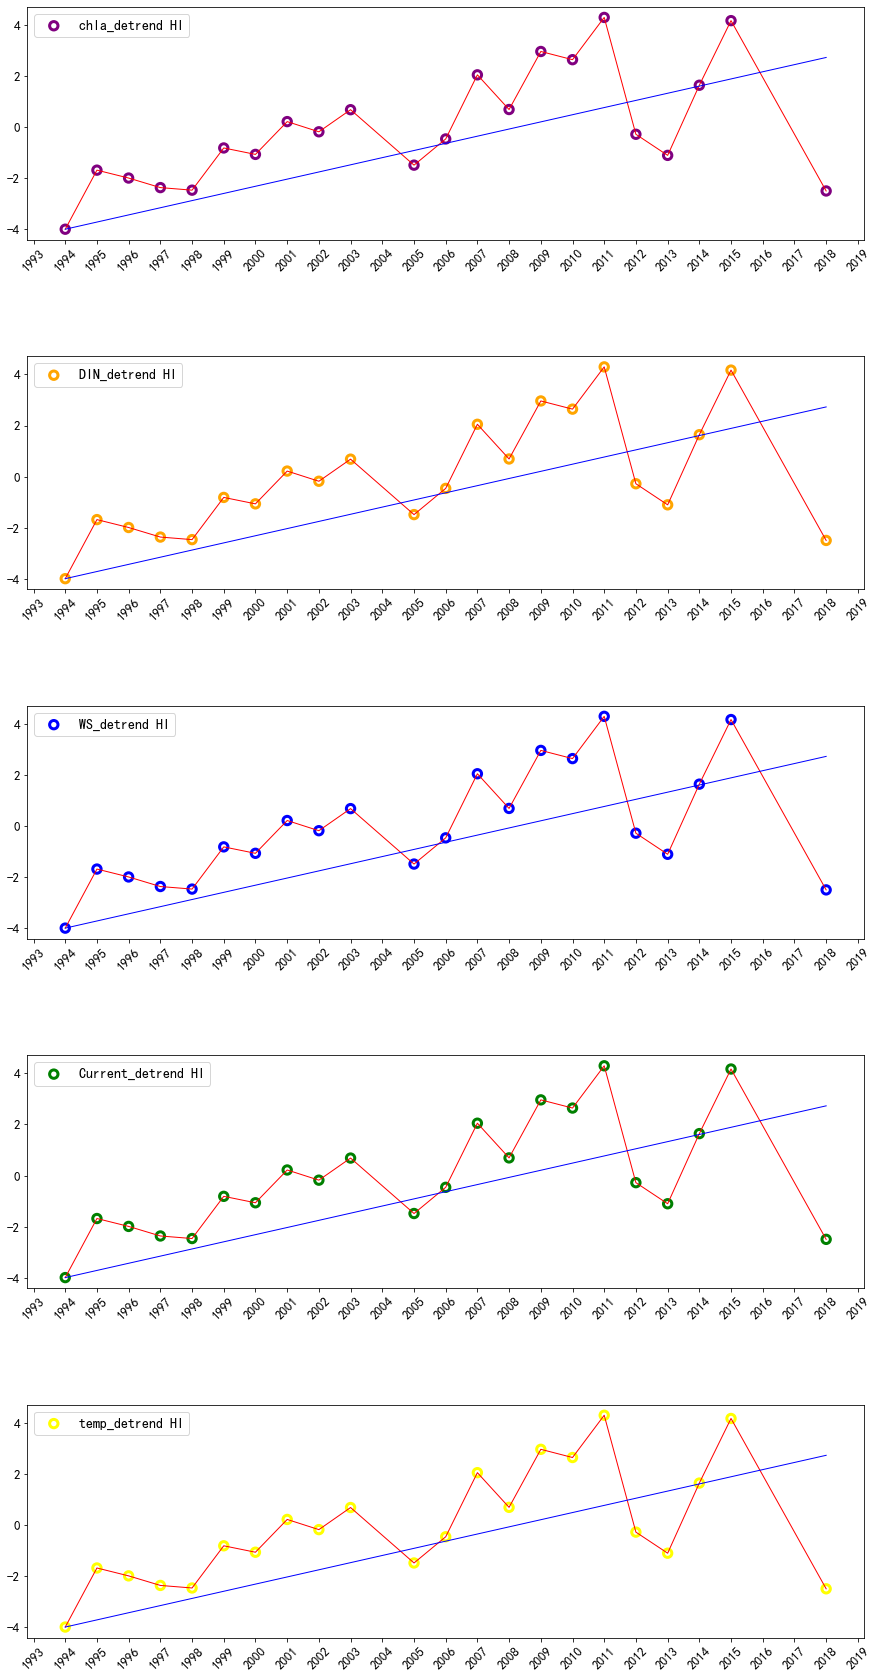

In [8]:
file_path = file_dir + name + '.mat'
data = loadmat(file_path)['X']
data = pd.DataFrame(data, columns=('chla', 'temp', 'DIN', 'density', 'chla_SD', 'std_temp_SD', \
                                   'DIN_SD', 'density_SD', 'WS', 'Current', 'HI', 'year'))
colors = ['purple', 'orange', 'blue', 'green', 'yellow', 'red']
detrend_data = data[selected_kinds]
# converting data type
selected_kinds = list(factors2)
selected_kinds.append('HI')
selected_kinds.append('year')
data = data[selected_kinds]
data['year'] = data['year'].astype('i4')
original_years = data['year']
data = data[[x not in year_range for x in data['year']]]
years = data['year']
x = [str(year) for year in years]
x = [datetime.strptime(i, '%Y') for i in x]
x = matplotlib.dates.date2num(x)
original_x = [str(year) for year in original_years]
original_x = [datetime.strptime(i, '%Y') for i in original_x]
original_x = matplotlib.dates.date2num(original_x)

subfigures = []
fig, axis = plt.subplots(5, 1, figsize=(15 * 1, 6 * 5))
for i in range(len(axis)):
    subfigures.append(axis[i])

plt.subplots_adjust(wspace=0, hspace=0.5)
for kk in range(len(factors2)):
    predict_data = data[list(factors2)].copy()
    predict_data.iloc[:, kk] = detrend_data.iloc[:, kk]
    predict_data = predict_data.values
    predict_data_mean = predict_data.mean(axis=0)
    predict_data_std = predict_data.std(axis=0)
    predict_data = (predict_data - predict_data_mean) / predict_data_std
    y_mean = data['HI'].values.mean(axis=0)
    y_std = data['HI'].values.std(axis=0)
    y = best_model.predict(predict_data) * y_std + y_mean
    k = sen_slope(y)
    km = KM(y)
    sen_line = k * np.arange(len(original_years)) + y[0]
    print(data.columns[kk] + '_detrend ' + 'HI: k = %.2f, KM = %.2f' % (k, km))
    subfigures[kk].plot(x, y, 'r-', linewidth=1, label='')
    subfigures[kk].scatter(x, y, marker='o', edgecolor=colors[kk], s=70, linewidths=3, color='', label=data.columns[kk] + '_detrend ' + 'HI')
    subfigures[kk].plot(original_x, sen_line, 'b-', linewidth=1, label='')
    subfigures[kk].set_xticklabels(labels=x, rotation=45, size = 13)
    subfigures[kk].tick_params(labelsize=13)
    subfigures[kk].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    subfigures[kk].xaxis.set_major_locator(matplotlib.dates.YearLocator())
    subfigures[kk].legend(loc='upper left', fontsize=14)
    
    
plt.savefig('./各变量去趋势化后HI结果_多元回归')

3
<class 'numpy.ndarray'>
[727929. 728294. 728659. 729025. 729390. 729755. 730120. 730486. 730851.
 731216. 731947. 732312. 732677. 733042. 733408. 733773. 734138. 734503.
 734869. 735234. 735599. 736695.]
chla: k = 0.06, KM = 0.62
DIN: k = 0.00, KM = 1.47
WS: k = -0.06, KM = -2.71
Current: k = -604.43, KM = -3.44
temp: k = 0.02, KM = 0.85
HI: k = 0.27, KM = 2.93


<ipython-input-12-a627d7a93d0c>:47: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  subfigure[j][kk].scatter(x, data.iloc[:, j*2+kk], marker='o', edgecolor=colors[j*2+kk], s=70, linewidths=3, color='')#, label='slope = {0:.2f}'.format(sen_slope(data.iloc[:, j*2+kk].values)))
<ipython-input-12-a627d7a93d0c>:47: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  subfigure[j][kk].scatter(x, data.iloc[:, j*2+kk], marker='o', edgecolor=colors[j*2+kk], s=70, linewidths=3, color='')#, label='slope = {0:.2f}'.format(sen_slope(data.iloc[:, j*2+kk].values)))
<ipython-input-12-a627d7a93d0c>:47: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  subfigure[j][kk].scatter(x, data.iloc[:, j*2+kk], marker='o', edgecolor=colors[j*2+kk], s=7

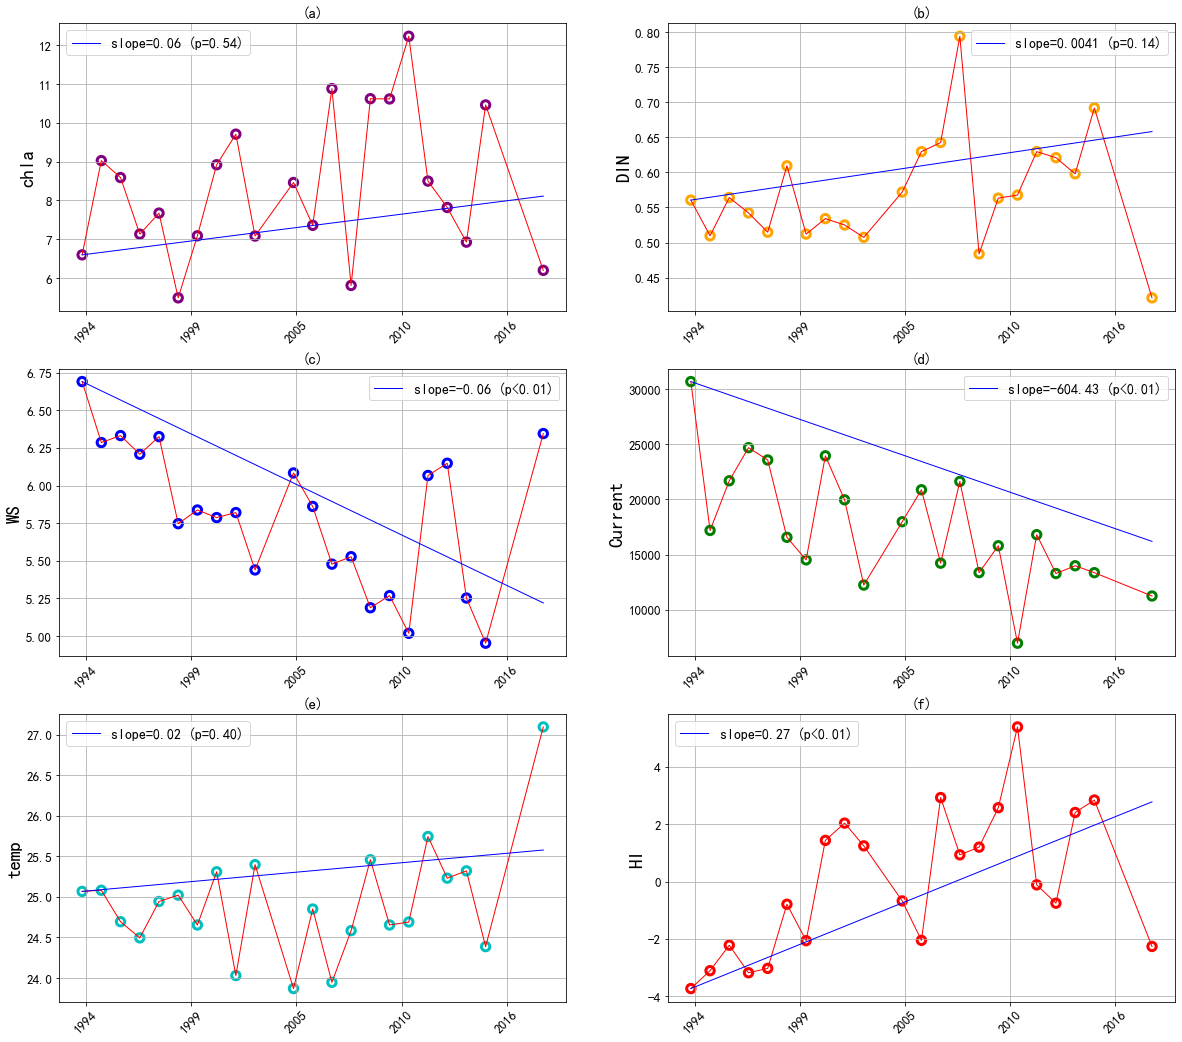

In [12]:
# 各变量去趋势化并作图，去趋势化结果存放在detrend_data中
file_path = file_dir + name + '.mat'
data = loadmat(file_path)['X']
data = pd.DataFrame(data, columns=('chla', 'temp', 'DIN', 'density', 'chla_SD', 'std_temp_SD', \
                                   'DIN_SD', 'density_SD', 'WS', 'Current', 'HI', 'year'))
colors = ['purple', 'orange', 'blue', 'green', 'c', 'red']
# converting data type
selected_kinds = list(factors2)
selected_kinds.append('HI')
selected_kinds.append('year')
data = data[selected_kinds]
detrend_data = data
data['year'] = data['year'].astype('i4')
original_years = data['year']
data = data[[x not in year_range for x in data['year']]]

fig, subfigure = plt.subplots(3, 2, figsize=(20 * 1, 3 * 6))

years = list(data['year'])
x = [str(year) for year in years]
x = [datetime.strptime(i, '%Y') for i in x]
x = matplotlib.dates.date2num(x)
print(x)
original_x = [str(year) for year in original_years]
original_x = [datetime.strptime(i, '%Y') for i in original_x]
original_x = matplotlib.dates.date2num(original_x)
tick_spacing = 2
for j in range(len(subfigure)):
    for kk in range(len(subfigure[0])):
        k = sen_slope(data.iloc[:, j*2+kk].values)
        km = KM(data.iloc[:, j*2+kk].values)
        p = 2*(1-norm.cdf(abs(km))) 
        print(data.columns[j*2+kk] + ': k = %.2f, KM = %.2f' % (k, km))
        sen_line = k * np.arange(len(original_years)) + data.iloc[0, j*2+kk]
        detrend_data.iloc[:, j*2+kk] = detrend_data.iloc[:, j*2+kk] - sen_line
        s = num2str(j*2+kk)
        subfigure[j][kk].set_title(s,fontsize = 15)
        subfigure[j][kk].set_ylabel((data.columns[j*2+kk]),fontsize = 19)
        subfigure[j][kk].grid()
        subfigure[j][kk].plot(x, data.iloc[:, j*2+kk], 'r-', linewidth=1, label='')
        subfigure[j][kk].scatter(x, data.iloc[:, j*2+kk], marker='o', edgecolor=colors[j*2+kk], s=70, linewidths=3, color='')#, label='slope = {0:.2f}'.format(sen_slope(data.iloc[:, j*2+kk].values)))
        if ( j*2+kk == 1):
            if(p < 0.01):
                subfigure[j][kk].plot(original_x, sen_line, 'b-', linewidth=1, label='slope={0:.4f} (p<0.01)'.format(sen_slope(data.iloc[:, j*2+kk].values)))
            else:
                subfigure[j][kk].plot(original_x, sen_line, 'b-', linewidth=1, label='slope={0:.4f} (p={1:.2f})'.format(sen_slope(data.iloc[:, j*2+kk].values),p))
        else:
            if(p < 0.01):
                subfigure[j][kk].plot(original_x, sen_line, 'b-', linewidth=1, label='slope={0:.2f} (p<0.01)'.format(sen_slope(data.iloc[:, j*2+kk].values)))
            else:
                subfigure[j][kk].plot(original_x, sen_line, 'b-', linewidth=1, label='slope={0:.2f} (p={1:.2f})'.format(sen_slope(data.iloc[:, j*2+kk].values),p))
        subfigure[j][kk].set_xticklabels(labels=x, rotation=45, size = 13)
        subfigure[j][kk].tick_params(labelsize=13)
        subfigure[j][kk].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
        subfigure[j][kk].legend(loc='best', fontsize=14)
        
detrend_data = detrend_data[[x not in year_range for x in detrend_data['year']]]
plt.savefig('./各变量趋势.png')

chla_detrend HI: k = 0.25, KM = 2.82
DIN_detrend HI: k = 0.26, KM = 2.88
WS_detrend HI: k = 0.05, KM = 0.45
Current_detrend HI: k = 0.28, KM = 2.88
temp_detrend HI: k = 0.27, KM = 2.88


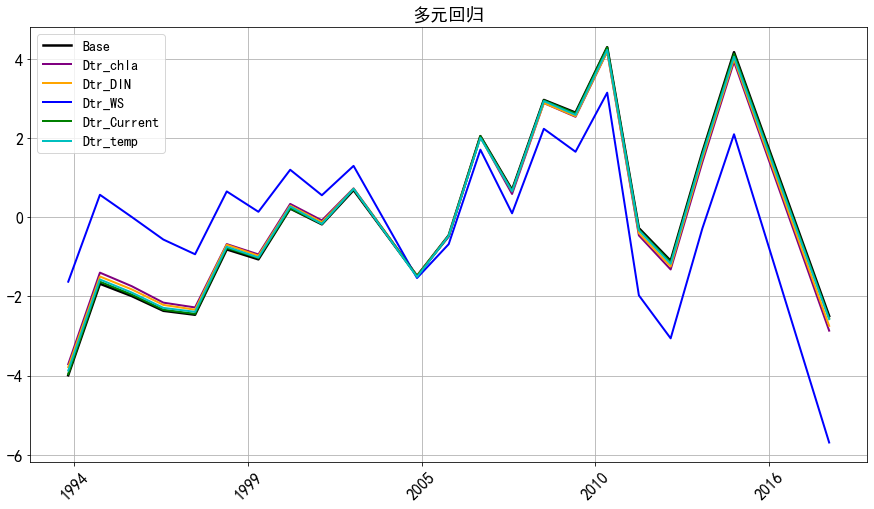

In [13]:
file_path = file_dir + name + '.mat'
data = loadmat(file_path)['X']
data = pd.DataFrame(data, columns=('chla', 'temp', 'DIN', 'density', 'chla_SD', 'std_temp_SD', \
                                   'DIN_SD', 'density_SD', 'WS', 'Current', 'HI', 'year'))
colors = ['purple', 'orange', 'blue', 'green', 'c', 'red']
# converting data type
selected_kinds = list(factors2)
selected_kinds.append('HI')
selected_kinds.append('year')
data = data[selected_kinds]
data['year'] = data['year'].astype('i4')
original_years = data['year']
data = data[[x not in year_range for x in data['year']]]
years = data['year']
x = [str(year) for year in years]
x = [datetime.strptime(i, '%Y') for i in x]
x = matplotlib.dates.date2num(x)
original_x = [str(year) for year in original_years]
original_x = [datetime.strptime(i, '%Y') for i in original_x]
original_x = matplotlib.dates.date2num(original_x)

subfigures = []
fig, axis = plt.subplots(1, 1, figsize=(15 * 1,  8))
subfigures.append(axis)

plt.subplots_adjust(wspace=0, hspace=0.5)
subfigures[0].set_title('多元回归')
for kk in range(len(factors2)):
    if kk == 0:
        predict_data = data[list(factors2)].copy()
        predict_data = predict_data.values
        predict_data_mean = predict_data.mean(axis=0)
        predict_data_std = predict_data.std(axis=0)
        predict_data = (predict_data - predict_data_mean) / predict_data_std
        y_mean = data['HI'].values.mean(axis=0)
        y_std = data['HI'].values.std(axis=0)
        y = best_model.predict(predict_data) * y_std + y_mean
        subfigures[0].plot(x, y, color = 'black', linewidth=2.5, label= 'Base')
    
    predict_data = data[list(factors2)].copy()
    predict_data.iloc[:, kk] = detrend_data.iloc[:, kk]
    predict_data = predict_data.values
    predict_data_mean = predict_data.mean(axis=0)
    predict_data_std = predict_data.std(axis=0)
    predict_data = (predict_data - predict_data_mean) / predict_data_std
    y_mean = data['HI'].values.mean(axis=0)
    y_std = data['HI'].values.std(axis=0)
    y = best_model.predict(predict_data) * y_std + y_mean
    k = sen_slope(y)
    km = KM(y)
    sen_line = k * np.arange(len(original_years)) + y[0]
    print(data.columns[kk] + '_detrend ' + 'HI: k = %.2f, KM = %.2f' % (k, km))
    subfigures[0].grid()
    
    subfigures[0].plot(x, y, color = colors[kk], linewidth=2, label= 'Dtr_'+ data.columns[kk] )
    subfigures[0].set_xticklabels(labels=x, rotation=45, size = 16)
    subfigures[0].tick_params(labelsize=16)
    subfigures[0].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    subfigures[0].legend(loc='upper left', fontsize=14)
    
plt.savefig('./各变量去趋势化后HI结果_多元回归')

chla_detrend HI: k = 0.25, KM = 2.82
DIN_detrend HI: k = 0.26, KM = 2.88
WS_detrend HI: k = 0.05, KM = 0.45
Current_detrend HI: k = 0.28, KM = 2.88
temp_detrend HI: k = 0.27, KM = 2.88
HI_detrend HI: k = 0.28, KM = 2.93


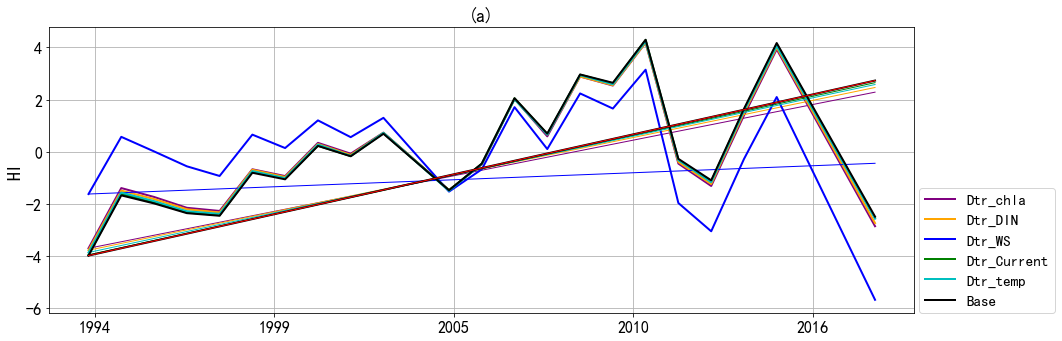

In [14]:
file_path = file_dir + name + '.mat'
data = loadmat(file_path)['X']
data = pd.DataFrame(data, columns=('chla', 'temp', 'DIN', 'density', 'chla_SD', 'std_temp_SD', \
                                   'DIN_SD', 'density_SD', 'WS', 'Current', 'HI', 'year'))
colors = ['purple', 'orange', 'blue', 'green', 'c', 'red']
# converting data type
selected_kinds = list(factors2)
selected_kinds.append('HI')
selected_kinds.append('year')
data = data[selected_kinds]
data['year'] = data['year'].astype('i4')
original_years = data['year']
data = data[[x not in year_range for x in data['year']]]
years = data['year']
x = [str(year) for year in years]
x = [datetime.strptime(i, '%Y') for i in x]
x = matplotlib.dates.date2num(x)
original_x = [str(year) for year in original_years]
original_x = [datetime.strptime(i, '%Y') for i in original_x]
original_x = matplotlib.dates.date2num(original_x)

subfigures = []
fig, axis = plt.subplots(1, 1, figsize=(15 * 1,  5))
subfigures.append(axis)

plt.subplots_adjust(wspace=0, hspace=0.5)
subfigures[0].set_title('(a)')
for kk in range(len(factors2)+1):
    if kk == len(factors2):
        predict_data = data[list(factors2)].copy()
        predict_data = predict_data.values
        predict_data_mean = predict_data.mean(axis=0)
        predict_data_std = predict_data.std(axis=0)
        predict_data = (predict_data - predict_data_mean) / predict_data_std
        y_mean = data['HI'].values.mean(axis=0)
        y_std = data['HI'].values.std(axis=0)
        y = best_model.predict(predict_data) * y_std + y_mean
        k = sen_slope(y)
        km = KM(y)
        sen_line = k * np.arange(len(original_years)) + y[0]
        print(data.columns[kk] + '_detrend ' + 'HI: k = %.2f, KM = %.2f' % (k, km))
        subfigures[0].plot(x, y, color = 'black', linewidth=2.0, label= 'Base')
        subfigures[0].plot(original_x, sen_line,'black', linewidth=2.0, label='')
    if kk != len(factors2):
        predict_data = data[list(factors2)].copy()
        predict_data.iloc[:, kk] = detrend_data.iloc[:, kk]
        predict_data = predict_data.values
        predict_data_mean = predict_data.mean(axis=0)
        predict_data_std = predict_data.std(axis=0)
        predict_data = (predict_data - predict_data_mean) / predict_data_std
        y_mean = data['HI'].values.mean(axis=0)
        y_std = data['HI'].values.std(axis=0)
        y = best_model.predict(predict_data) * y_std + y_mean
        k = sen_slope(y)
        km = KM(y)
        sen_line = k * np.arange(len(original_years)) + y[0]
        print(data.columns[kk] + '_detrend ' + 'HI: k = %.2f, KM = %.2f' % (k, km))
        subfigures[0].grid()
        subfigures[0].set_ylabel(('HI'),fontsize=18)
        #subfigures[0].set_xlabel(('year'),fontsize=18)
        subfigures[0].plot(x, y, color = colors[kk], linewidth=2, label= 'Dtr_'+ data.columns[kk] )
        
    subfigures[0].plot(original_x, sen_line,color = colors[kk], linewidth=1, label='')
    subfigures[0].set_xticklabels(labels=x, rotation=0, size = 16)
    subfigures[0].tick_params(labelsize=16)
    subfigures[0].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    
    subfigures[0].legend(bbox_to_anchor = (1.005,0),loc = 3,borderaxespad = 0)

plt.tight_layout()
plt.savefig('./各变量去趋势化后HI结果_多元回归')